<a href="https://colab.research.google.com/github/shivampip/Journey2AI/blob/master/ImageSegmentationTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Problem source](https://www.kaggle.com/c/carvana-image-masking-challenge)

In [0]:
import os
import glob
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from PIL import Image

In [0]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python import keras
from tensorflow.python.keras import backend as K

### Get all files

In [0]:
import os

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()

In [0]:
import kaggle

In [0]:
competition_name = 'carvana-image-masking-challenge'

In [0]:
# Download data from Kaggle and unzip the files of interest. 
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    print("getting train.zip")
    load_data_from_zip(competition, 'train.zip')
    print("getting train_masks")
    load_data_from_zip(competition, 'train_masks.zip')
    print("gettign train_masks.csv")
    load_data_from_zip(competition, 'train_masks.csv.zip')

In [16]:
get_data(competition_name)

getting train.zip
getting train_masks
gettign train_masks.csv


In [0]:
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

In [0]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [0]:
ls -R

In [31]:
df_train.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [32]:
ids_train.head()

0    00087a6bd4dc_01
1    00087a6bd4dc_02
2    00087a6bd4dc_03
3    00087a6bd4dc_04
4    00087a6bd4dc_05
Name: img, dtype: object

In [0]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [0]:
from sklearn.model_selection import train_test_split
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [39]:
print(len(x_train_filenames))
print(len(x_val_filenames))

4070
1018


In [40]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 4070
Number of validation examples: 1018


In [41]:
print(x_train_filenames[:10])
print(y_train_filenames[:10])

['carvana-image-masking-challenge/train/69915dab0755_16.jpg', 'carvana-image-masking-challenge/train/695f39dfac16_04.jpg', 'carvana-image-masking-challenge/train/2267f4aa0d2c_13.jpg', 'carvana-image-masking-challenge/train/562706000bd7_15.jpg', 'carvana-image-masking-challenge/train/917f262f1608_06.jpg', 'carvana-image-masking-challenge/train/fce0ba5b8ed7_07.jpg', 'carvana-image-masking-challenge/train/93881caf9f70_10.jpg', 'carvana-image-masking-challenge/train/eb07e3f63ad2_09.jpg', 'carvana-image-masking-challenge/train/78bfb9c780db_10.jpg', 'carvana-image-masking-challenge/train/d3d0d2662918_12.jpg']
['carvana-image-masking-challenge/train_masks/69915dab0755_16_mask.gif', 'carvana-image-masking-challenge/train_masks/695f39dfac16_04_mask.gif', 'carvana-image-masking-challenge/train_masks/2267f4aa0d2c_13_mask.gif', 'carvana-image-masking-challenge/train_masks/562706000bd7_15_mask.gif', 'carvana-image-masking-challenge/train_masks/917f262f1608_06_mask.gif', 'carvana-image-masking-chall

In [0]:
from binarypipe import imagepipe as ip

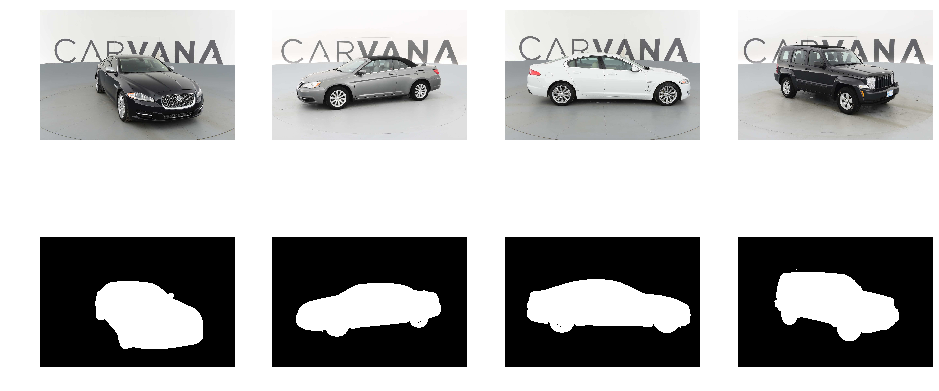

In [50]:
ip.plot(x_train_filenames[:4]+y_train_filenames[:4], count=-1, scale=2.0)